# Tree shape diversity

### The plot elements below will be saved to `/analysis/output/NDS-LB/`

In [31]:
import glob
import pickle
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm, SymLogNorm

## Load GC trees and constuct a data frame of statistics

In [32]:
results = "../nextflow/results/latest"

In [33]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), f"{PR_str[3]}-{PR_str[2]}"

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)

trees = {}
for file in files:
    mouse, gc = gc_key(file)
    # 20 day only
    if mouse not in range(6 + 1):
        continue
    trees[f"mouse{mouse}_GC{gc}"] = pickle.load(open(file, "rb"))


print(f"loaded {len(trees)} GC trees")

loaded 67 GC trees


In [34]:
stat = "REI"
# taus = np.logspace(-2, 0, 10)
taus = np.linspace(0.05, 1, 20)
# taus = [0.05, 0.1, 1]

# stat = "LBI"
# taus = np.logspace(-1, 1, 50)

In [35]:
def calc_tree_stat(tree, stat, tau):
    if stat == "REI":
        total_abundance = sum(node.abundance for node in tree.tree.traverse())
        for node in tree.tree.traverse():
            node.REI = sum(node2.abundance * tau ** node2.get_distance(node) for node2 in node.traverse()) / total_abundance
    elif stat.startswith("LB"):
        tree.local_branching(tau=tau)
    else:
        raise ValueError(f"unknown stat {stat}")

In [36]:
df = pd.DataFrame()

row = 0
for tau in taus:
    for mouse_gc, tree in trees.items():
        mouse, gc = mouse_gc.split("_")
        mouse = mouse.lstrip("mouse")

        calc_tree_stat(tree, stat, tau)
        
        gc = gc.lstrip("GC")
        df.loc[row, "τ"] = tau
        df.loc[row, "mouse"] = mouse
        df.loc[row, "germinal center"] = gc
        
        abundances = np.array([node.abundance for node in tree.tree.traverse()])

        if len(tree.tree.children) == 1:
            root = tree.tree.children[0]
        else:
            root = tree.tree
        clade_sizes = [sum(node.abundance for node in child.traverse()) for child in root.children]
        df.loc[row, "cells sampled"] = sum(abundances)
        df.loc[row, "normalized dominance score"] = max(clade_sizes) / sum(clade_sizes)
        df.loc[row, f"maximum {stat}"] = np.nanmax([getattr(node, stat) for node in tree.tree.traverse()])    
        
        # note: additive delta_bind for now
        delta_bind_dat = []
        for node in tree.tree.traverse():
            if not np.isnan(node.delta_bind_CGG_FVS_additive):
                for _ in range(node.abundance):
                    delta_bind_dat.append(node.delta_bind_CGG_FVS_additive)
        df.loc[row, "max Δaffinity"] = np.nanmax(delta_bind_dat)
        df.loc[row, "95th percentile Δaffinity"] = np.percentile(delta_bind_dat, 95)
        df.loc[row, "mean Δaffinity"] = np.nanmean(delta_bind_dat)
        df.loc[row, "median Δaffinity"] = np.nanmedian(delta_bind_dat)

        max_stat_idx = np.nanargmax([getattr(node, stat) for node in tree.tree.traverse()])
        df.loc[row, f"Δaffinity of max {stat} node"] = [node.delta_bind_CGG_FVS_additive for node in tree.tree.traverse()][max_stat_idx]
        df.loc[row, f"ΔΔaffinity of max {stat} node"] = [node.delta_bind_CGG_FVS_additive - (node.up.delta_bind_CGG_FVS_additive if node.up is not None else 0) for node in tree.tree.traverse()][max_stat_idx]
        df.loc[row, f"max {stat} node is root"] = max_stat_idx == 0

        row += 1

df

,τ,mouse,germinal center,cells sampled,normalized dominance score,maximum REI,max Δaffinity,95th percentile Δaffinity,mean Δaffinity,median Δaffinity,Δaffinity of max REI node,ΔΔaffinity of max REI node,max REI node is root
0,0.05,1,1-RP,89.0,0.932584,0.081041,1.75955,1.260416,0.673078,1.124685,1.16671,0.00483,False
1,0.05,1,11-RB,66.0,0.742424,0.102516,1.87747,1.294376,0.788601,1.065520,1.06552,0.73452,False
2,0.05,1,12-RB,49.0,0.530612,0.063474,2.19856,1.475176,0.892681,1.102810,1.19101,-0.00581,False
3,0.05,1,13-RB,88.0,0.306818,0.046621,2.34731,2.034419,1.083640,1.198050,1.17873,0.84773,False
4,0.05,1,14-RB,84.0,0.452381,0.037683,2.53366,2.407759,0.714963,0.825960,0.82596,0.82596,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,1.00,5,83-RP,78.0,0.467532,1.000000,1.45983,1.196820,0.074858,0.115775,0.00000,0.00000,True
1336,1.00,6,74-RP,78.0,0.884615,1.000000,2.06377,1.395440,0.309517,0.557385,0.00000,0.00000,True
1337,1.00,6,75-RP,70.0,0.985714,1.000000,1.19682,1.171988,-0.276520,0.282890,0.00000,0.00000,True
1338,1.00,6,76-RP,81.0,0.580247,1.000000,1.37717,1.077752,0.017909,0.329570,0.00000,0.00000,True


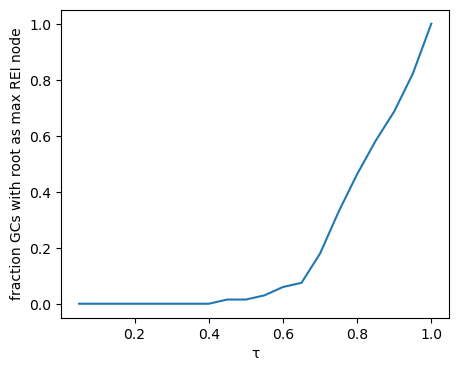

In [37]:
df.groupby("τ")[f"max {stat} node is root"].agg(lambda group: group.astype(int).sum() / len(group)).plot(xlabel="τ", ylabel=f"fraction GCs with root as max {stat} node", figsize=(5, 4));
# plt.xscale("log")

In [38]:
taus

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

/opt/miniconda3/envs/replay/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_1224/3456911258.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


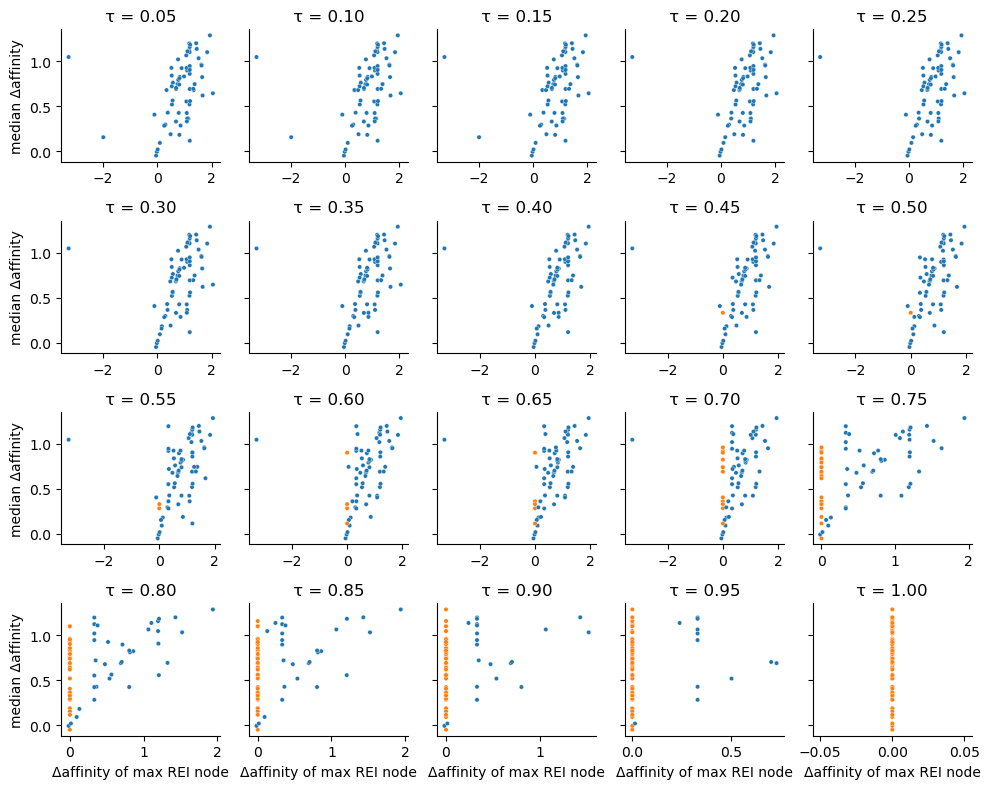

In [39]:
g = sns.relplot(data=df.loc[df.τ.isin(taus)], x=f"Δaffinity of max {stat} node", y="median Δaffinity", col="τ",
                col_wrap=5, hue="max REI node is root", height=2, s=10, legend=False,
                facet_kws={"sharex": False, "sharey": True})
for tau, ax in zip(taus, g.axes):
    ax.set_title(f"τ = {tau:.2f}")
plt.tight_layout()
plt.show()


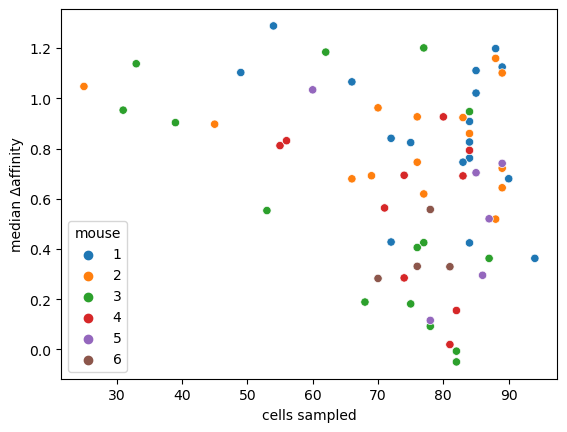

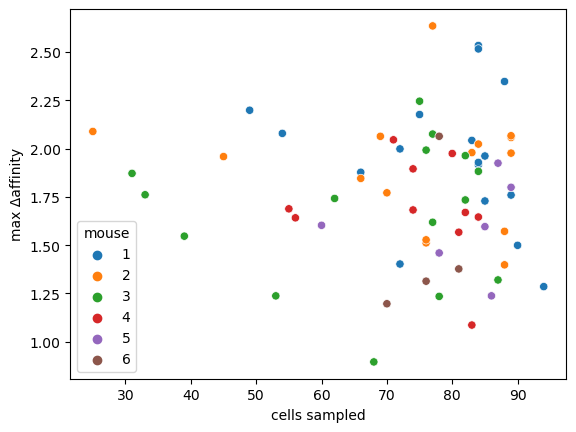

In [40]:
sns.scatterplot(data=df.loc[df.τ == taus[0]], x="cells sampled", y=f"median Δaffinity", hue="mouse")
plt.show()

sns.scatterplot(data=df.loc[df.τ == taus[0]], x="cells sampled", y=f"max Δaffinity", hue="mouse")
plt.show()

/opt/miniconda3/envs/replay/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_1224/4189382422.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


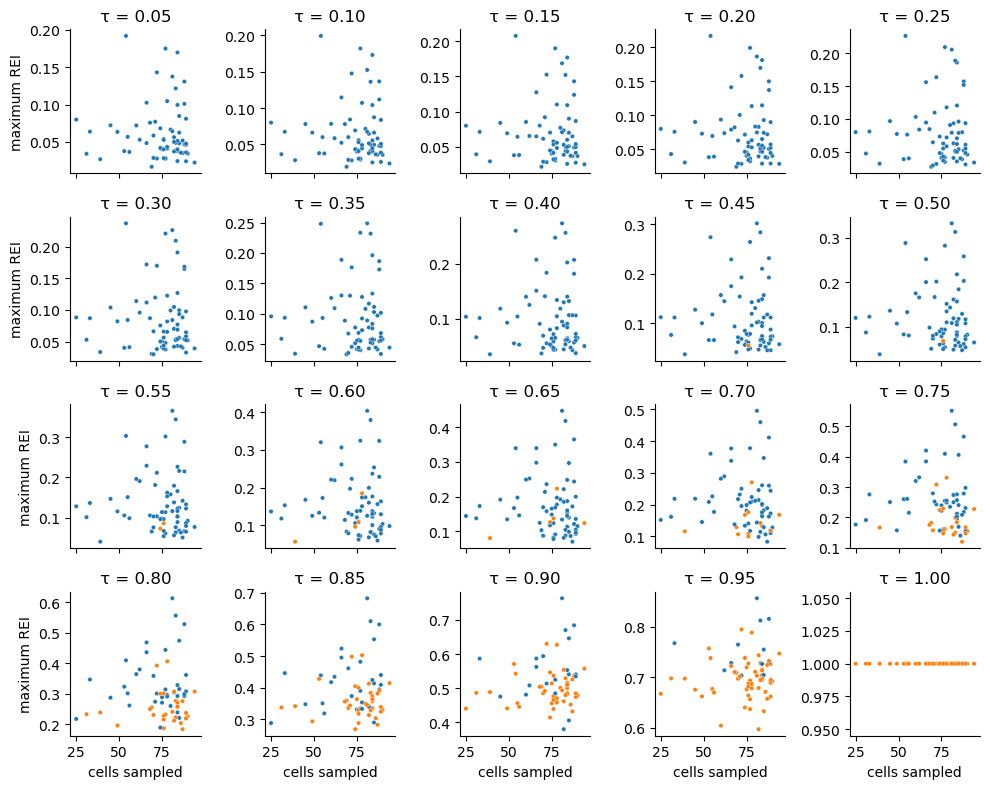

In [41]:
g = sns.relplot(data=df.loc[df.τ.isin(taus)], x="cells sampled", y=f"maximum REI", col="τ",
                col_wrap=5, hue="max REI node is root", height=2, s=10, legend=False,
                facet_kws={"sharex": True, "sharey": False})
for tau, ax in zip(taus, g.axes):
    ax.set_title(f"τ = {tau:.2f}")
plt.tight_layout()
plt.show()

/opt/miniconda3/envs/replay/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_1224/3049851020.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


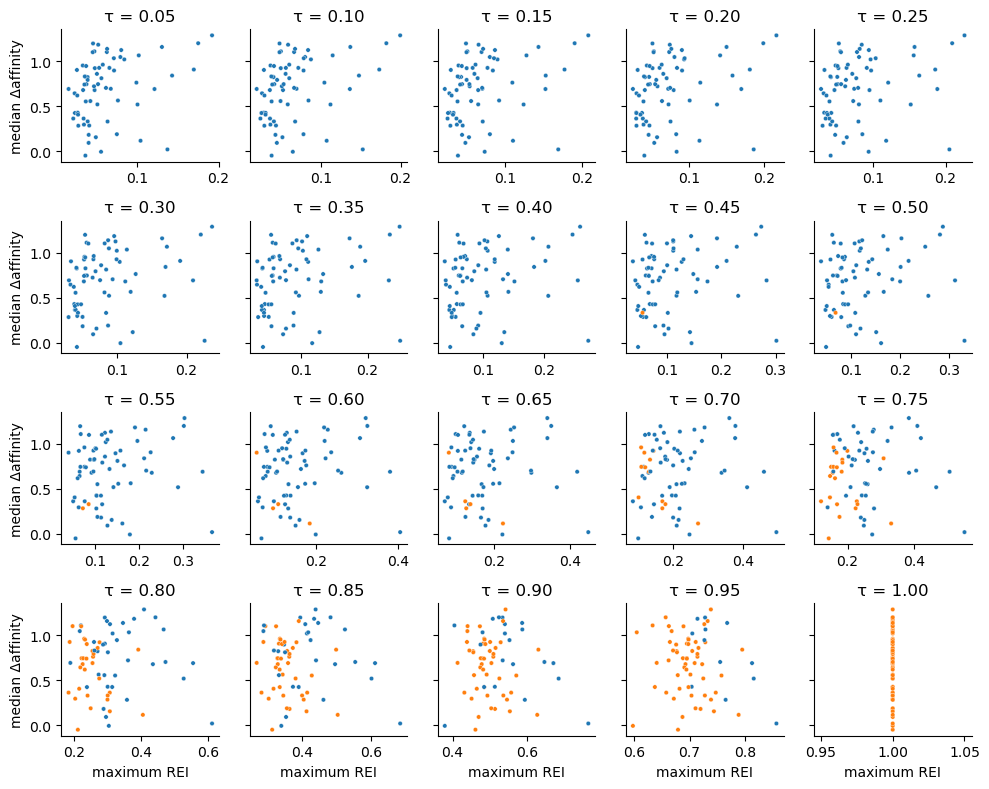

In [42]:
g = sns.relplot(data=df.loc[df.τ.isin(taus)], x=f"maximum REI", y="median Δaffinity", col="τ",
                col_wrap=5, hue="max REI node is root", height=2, s=10, legend=False,
                facet_kws={"sharex": False, "sharey": True})
for tau, ax in zip(taus, g.axes):
    ax.set_title(f"τ = {tau:.2f}")
plt.tight_layout()
plt.show()

/opt/miniconda3/envs/replay/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_1224/1049704957.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


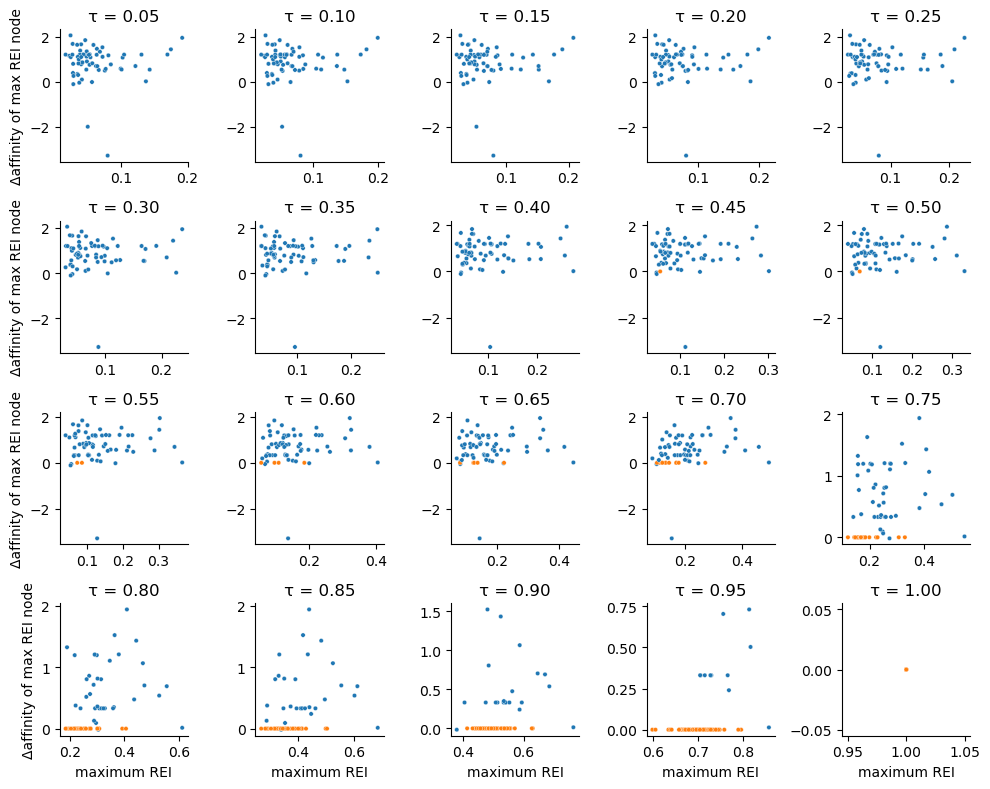

In [43]:
g = sns.relplot(data=df.loc[df.τ.isin(taus)], x=f"maximum REI", y=f"Δaffinity of max {stat} node", col="τ",
                col_wrap=5, hue="max REI node is root", height=2, s=10, legend=False,
                facet_kws={"sharex": False, "sharey": False})
for tau, ax in zip(taus, g.axes):
    ax.set_title(f"τ = {tau:.2f}")
plt.tight_layout()
plt.show()

/opt/miniconda3/envs/replay/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


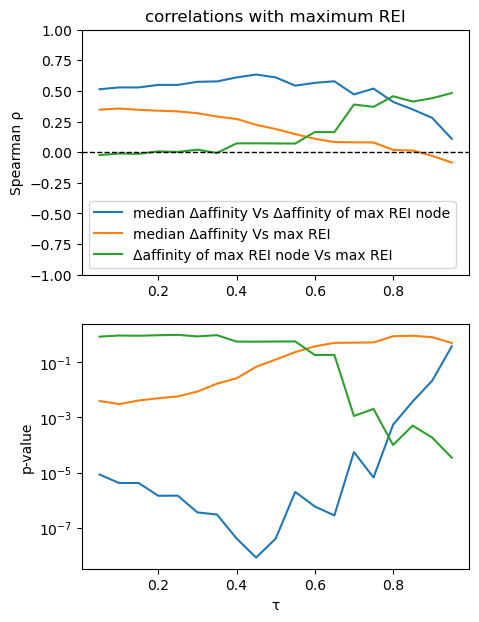

In [44]:
cor_df = pd.DataFrame()
for gc, group_df in df.groupby("τ"):
    ρ_node, p_node = sp.stats.spearmanr(group_df[f"Δaffinity of max {stat} node"], group_df[f"maximum {stat}"])
    ρ_gc, p_gc = sp.stats.spearmanr(group_df[f"median Δaffinity"], group_df[f"maximum {stat}"])
    ρ_aff, p_aff = sp.stats.spearmanr(group_df[f"median Δaffinity"], group_df[f"Δaffinity of max {stat} node"])
    cor_df.loc[gc, "ρ_node"] = ρ_node
    cor_df.loc[gc, "ρ_gc"] = ρ_gc
    cor_df.loc[gc, "p_node"] = p_node
    cor_df.loc[gc, "p_gc"] = p_gc
    cor_df.loc[gc, "ρ_aff"] = ρ_aff
    cor_df.loc[gc, "p_aff"] = p_aff

plt.figure(figsize=(5, 7))
plt.subplot(2, 1, 1)
plt.title(f"correlations with maximum {stat}")
sns.lineplot(data=cor_df, x=cor_df.index, y="ρ_aff", label=f"median Δaffinity Vs Δaffinity of max {stat} node")
sns.lineplot(data=cor_df, x=cor_df.index, y="ρ_gc", label=f"median Δaffinity Vs max {stat}")
sns.lineplot(data=cor_df, x=cor_df.index, y="ρ_node", label=f"Δaffinity of max {stat} node Vs max {stat}")
plt.axhline(0, color="k", ls="--", lw=1)
# plt.xlabel("τ")
plt.ylabel("Spearman ρ")
plt.ylim(-1, 1)
plt.legend()

plt.subplot(2, 1, 2)
sns.lineplot(data=cor_df, x=cor_df.index, y="p_aff")
sns.lineplot(data=cor_df, x=cor_df.index, y="p_gc")
sns.lineplot(data=cor_df, x=cor_df.index, y="p_node")
plt.xlabel("τ")
plt.ylabel("p-value")
plt.yscale("log")
plt.show()

In [45]:
# outcome = "mean Δaffinity"
outcome = "median Δaffinity"
# outcome = "95th percentile Δaffinity"
# outcome = f"Δaffinity of max {stat} node"
# outcome = f"ΔΔaffinity of max {stat} node"

In [46]:
# tau = taus[np.where(tau_cor_df.ρ > 0, tau_cor_df.p, 1).argmin()]
tau = taus[9]
tau

0.49999999999999994

Need to recompute tree stats using the chosen $\tau$

In [47]:
for tree in trees.values():
    calc_tree_stat(tree, stat, tau)

In [48]:
df = df.loc[df["τ"] == tau].sort_values(f"maximum {stat}").reset_index()
df

,index,τ,mouse,germinal center,cells sampled,normalized dominance score,maximum REI,max Δaffinity,95th percentile Δaffinity,mean Δaffinity,median Δaffinity,Δaffinity of max REI node,ΔΔaffinity of max REI node,max REI node is root
0,646,0.5,3,64-RA,39.0,0.435897,0.038462,1.54676,1.282531,0.656919,0.90327,1.19437,-0.00245,False
1,642,0.5,3,56-RB,87.0,0.413793,0.047593,1.32005,1.206908,0.392479,0.36270,1.10113,0.90825,False
2,640,0.5,3,46-LP,82.0,0.390244,0.048780,1.73409,1.092767,-0.390786,-0.04957,-0.04850,0.00754,False
3,644,0.5,3,58-LB,76.0,0.684211,0.050164,1.99217,1.754000,0.022117,0.40602,-0.11017,-0.00889,False
4,622,0.5,2,23-RP,69.0,0.768116,0.050767,2.06354,1.661450,-0.151775,0.69180,1.18666,0.00000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,632,0.5,2,38-LA,88.0,0.988636,0.258001,1.39829,0.729844,0.102329,0.51905,0.53801,0.03494,False
63,648,0.5,3,66-LA,77.0,0.727273,0.281859,2.07526,1.464745,0.273878,1.20073,1.43247,0.35972,False
64,619,0.5,1,7-RI,54.0,0.796296,0.287833,2.07873,2.022994,0.530009,1.28830,1.94137,0.85566,False
65,657,0.5,4,70-RA,83.0,0.987952,0.312688,1.08660,0.732249,0.448197,0.69114,0.69114,-0.03998,False


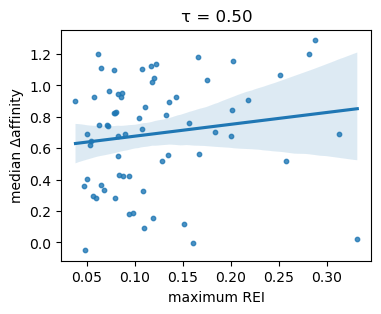

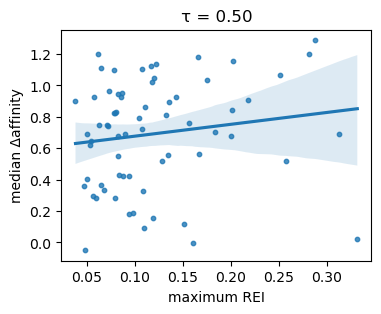

In [49]:
plt.figure(figsize=(4, 3))
sns.regplot(data=df, x=f"maximum {stat}", y=outcome, scatter_kws=dict(s=10))
plt.title(f"τ = {tau:.2f}")
plt.show()

# plt.figure(figsize=(4, 3))
# sns.regplot(data=df.loc[df[outcome] != 0], x=f"maximum {stat}", y=outcome, scatter_kws=dict(s=10), label="no roots")
# plt.title(f"τ = {tau:.2f}")
# plt.legend()
# plt.show()

plt.figure(figsize=(4, 3))
sns.regplot(data=df, x=f"maximum {stat}", y="median Δaffinity", scatter_kws=dict(s=10))
plt.title(f"τ = {tau:.2f}")
plt.show()

In [50]:
thresh = 0.15

In [51]:
output_dir = "output/NDS-LB"

In [52]:
df.to_csv(f"{output_dir}/data.csv")

## Rank plot of total GC cell abundance 

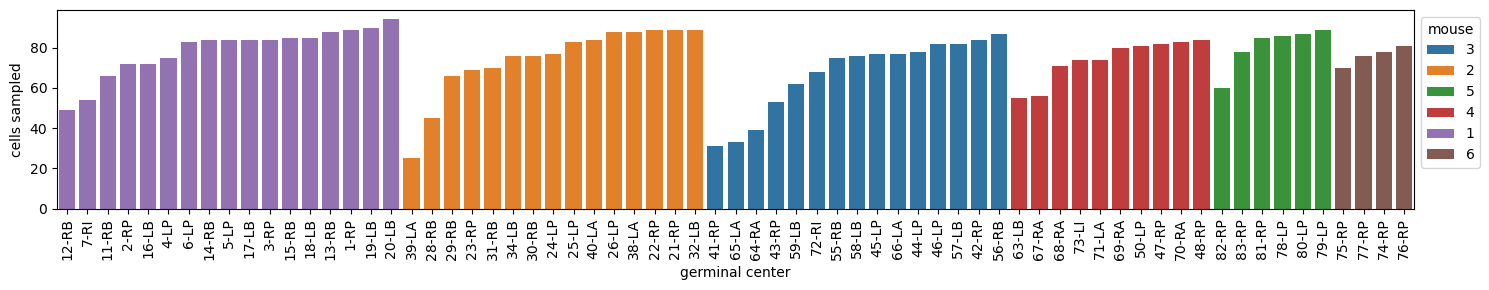

In [53]:
plt.figure(figsize=(15, 3))
ax = sns.barplot(data=df.sort_values(["mouse", "cells sampled"]), x="germinal center", y="cells sampled", hue="mouse",
                 hue_order=df.mouse.unique(),
                 dodge=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f"{output_dir}/abundances.pdf")
plt.show()

## Plot tree shape stats in a scatter plot, and render some example trees
For each tree we render it colored by fitness statistic, then by affinity, and by fitness stat

83-RP REI


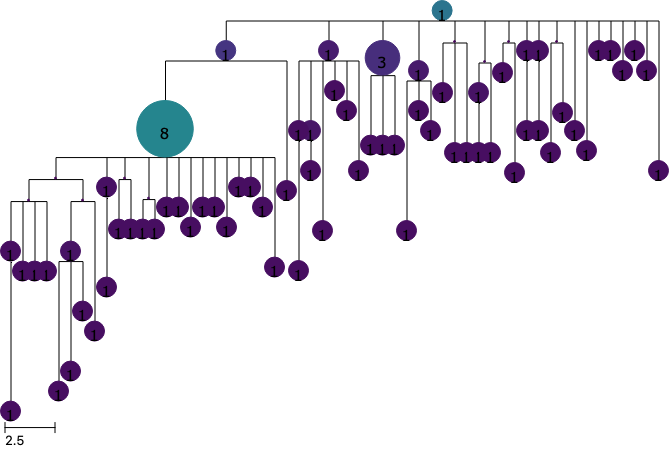

83-RP Δaffinity


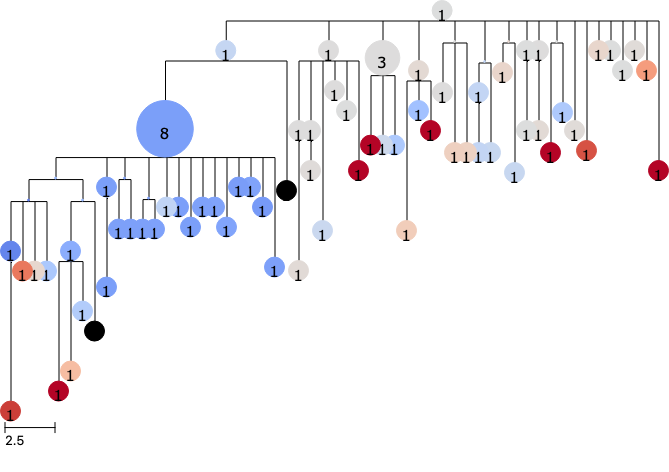

17-LB REI


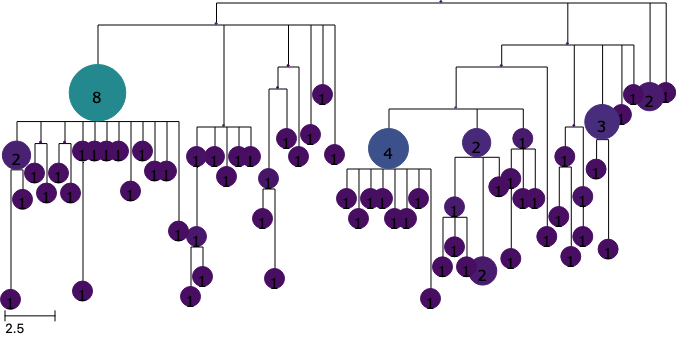

17-LB Δaffinity


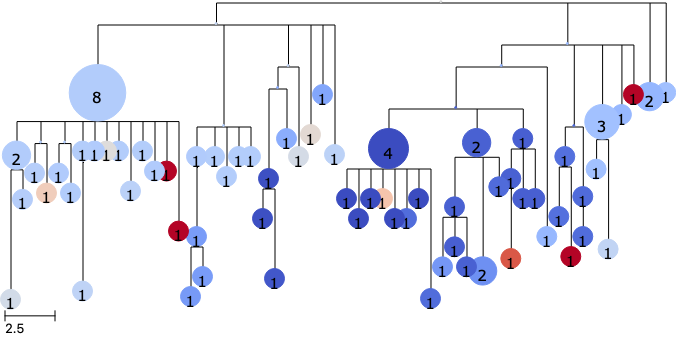

57-LB REI


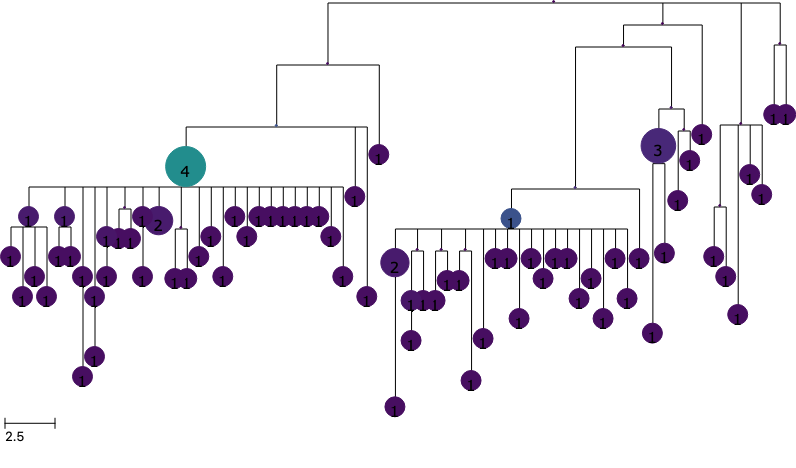

57-LB Δaffinity


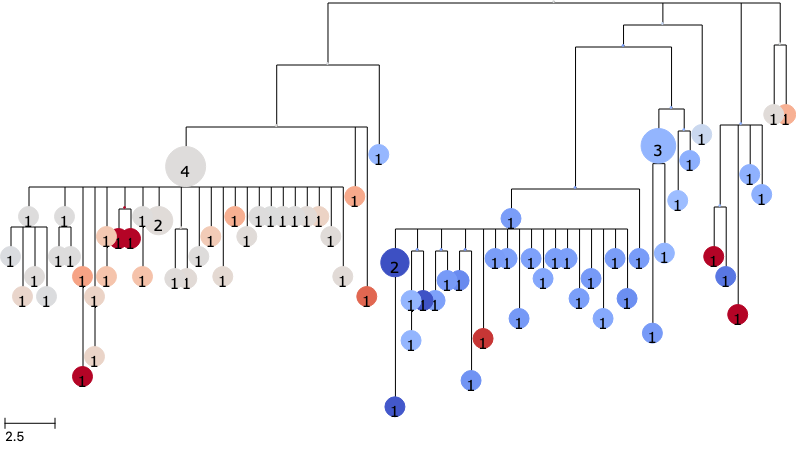

59-LB REI


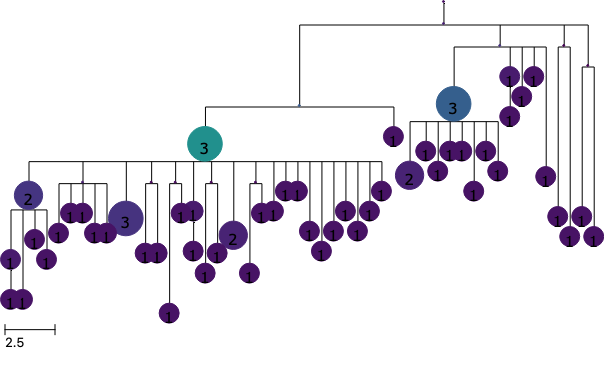

59-LB Δaffinity


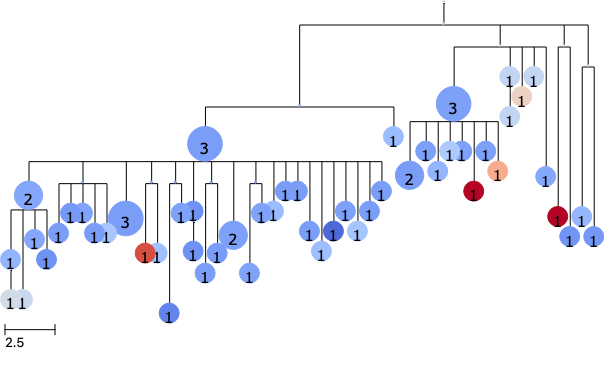

68-RA REI


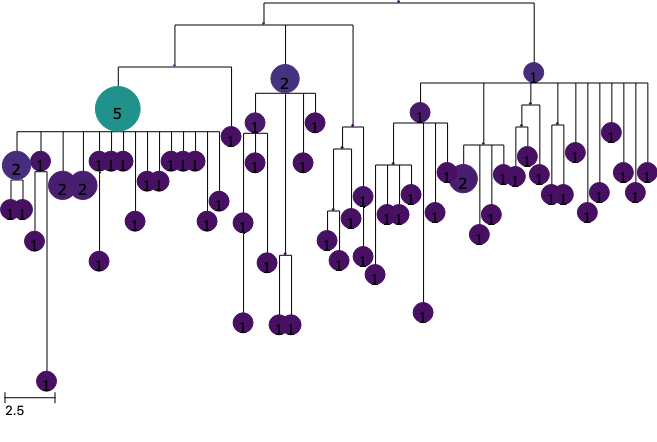

68-RA Δaffinity


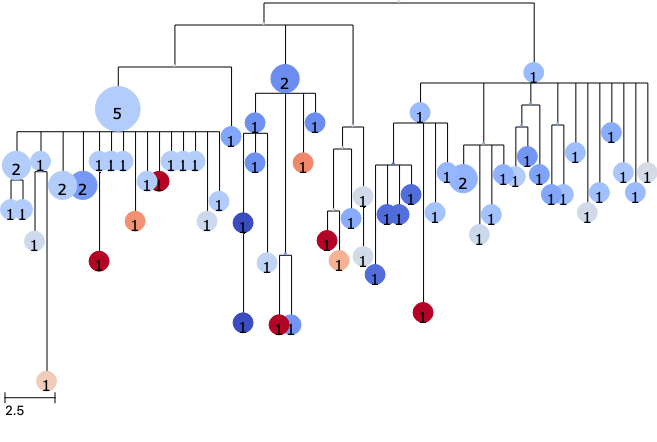

82-RP REI


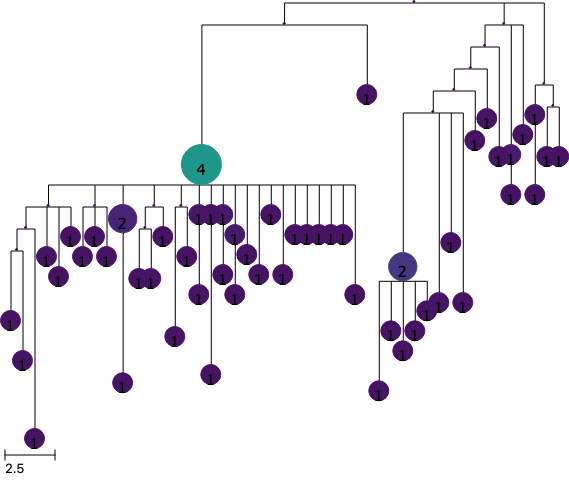

82-RP Δaffinity


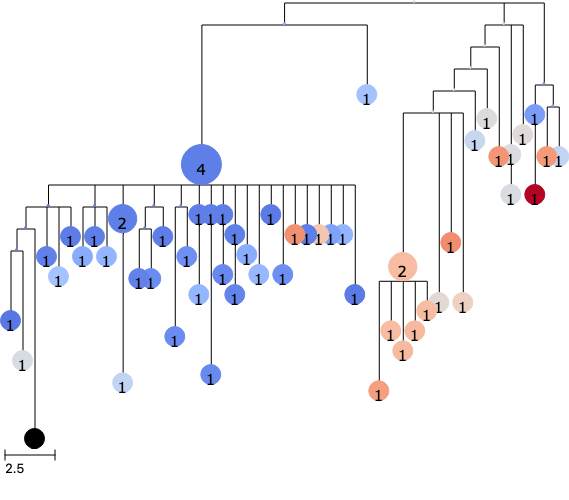

81-RP REI


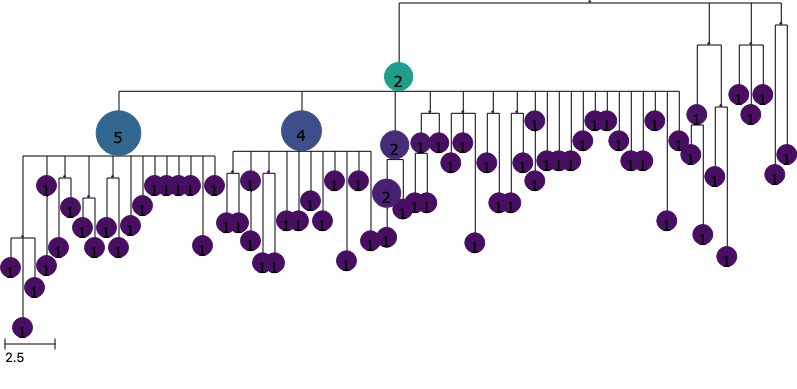

81-RP Δaffinity


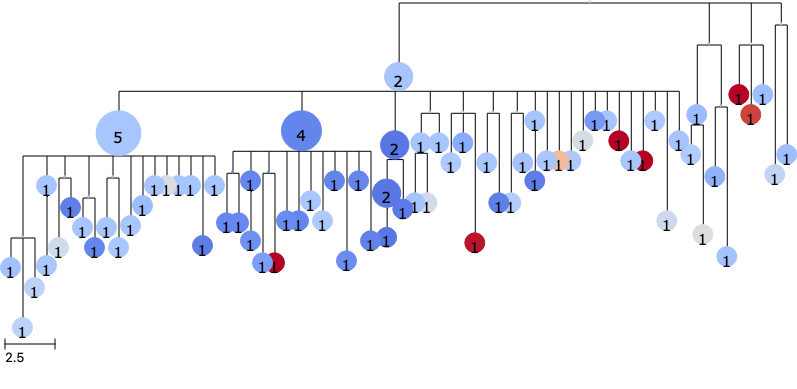

29-RB REI


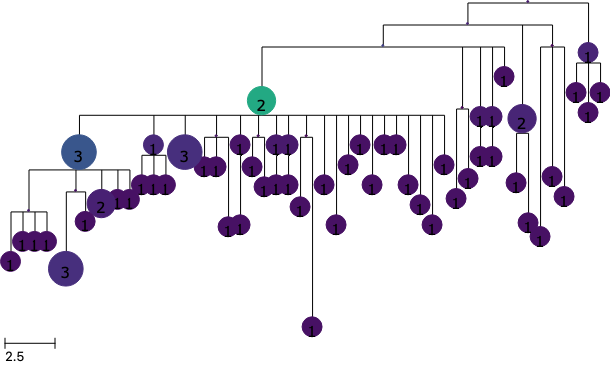

29-RB Δaffinity


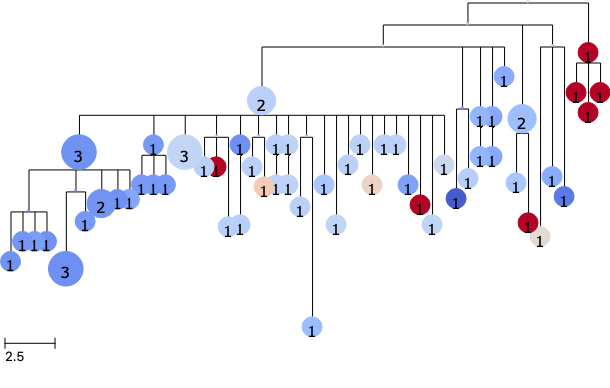

16-LB REI


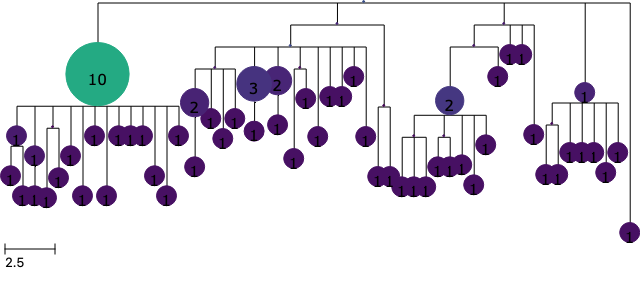

16-LB Δaffinity


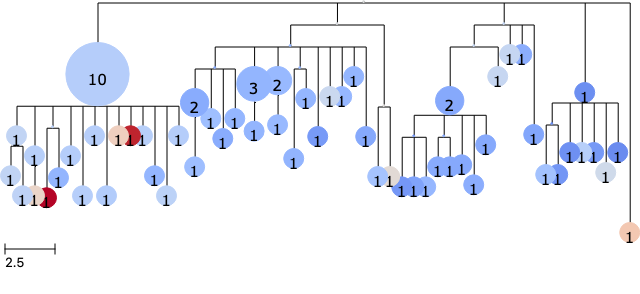

26-LP REI


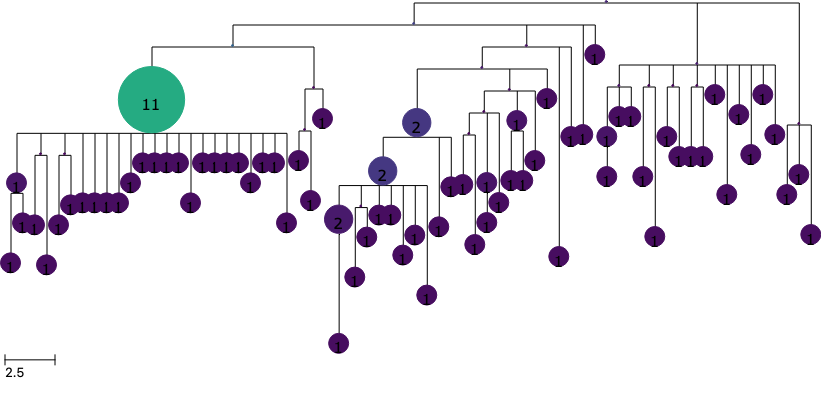

26-LP Δaffinity


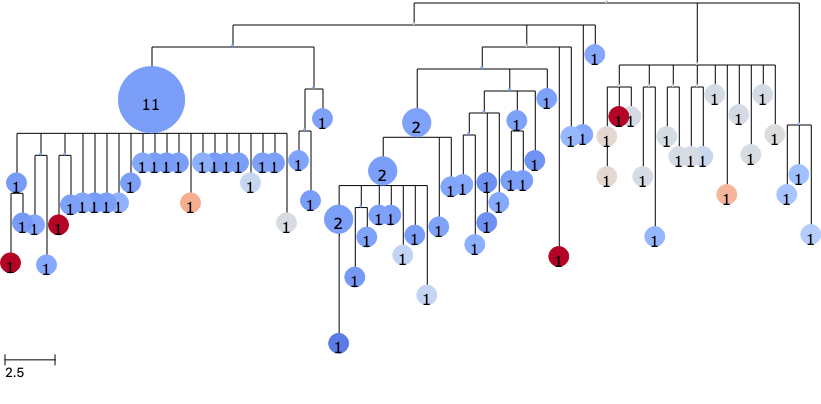

3-RP REI


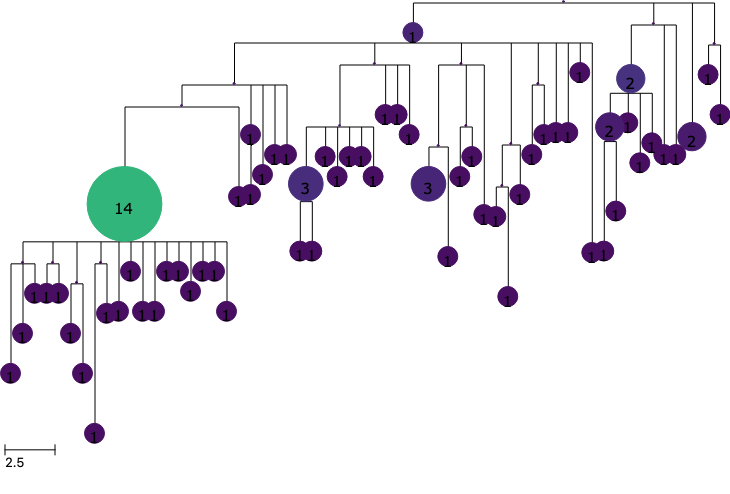

3-RP Δaffinity


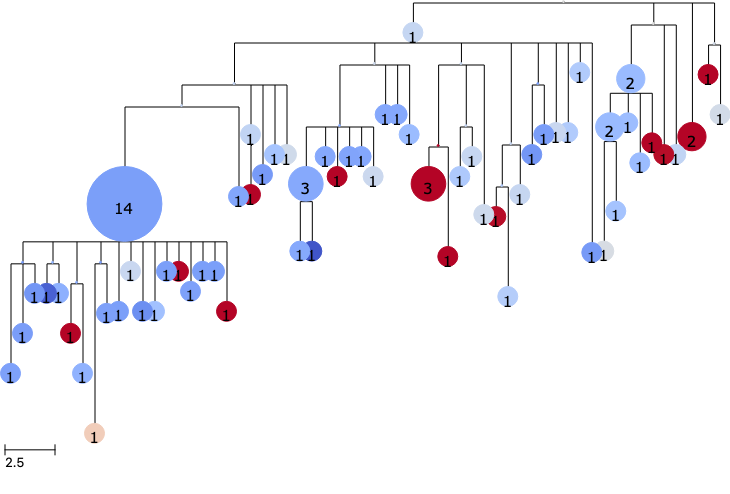

11-RB REI


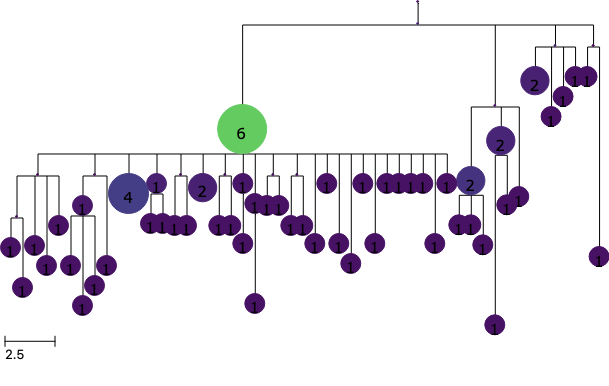

11-RB Δaffinity


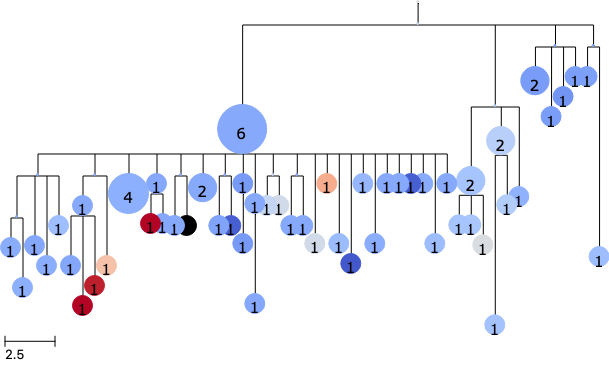

38-LA REI


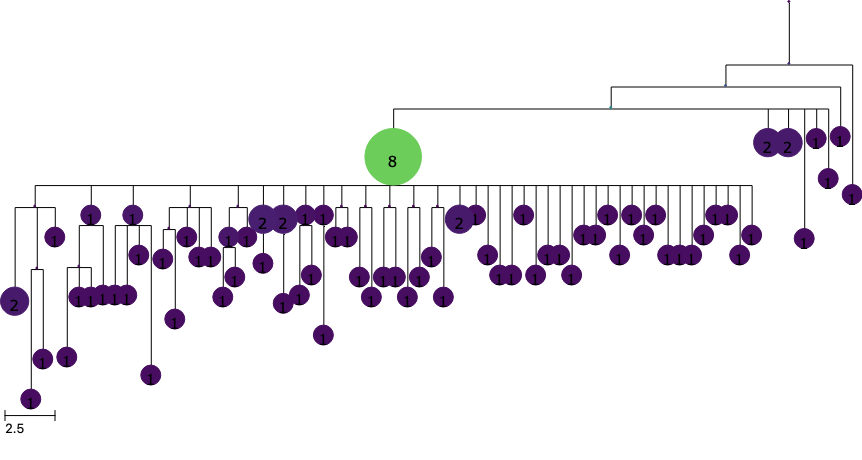

38-LA Δaffinity


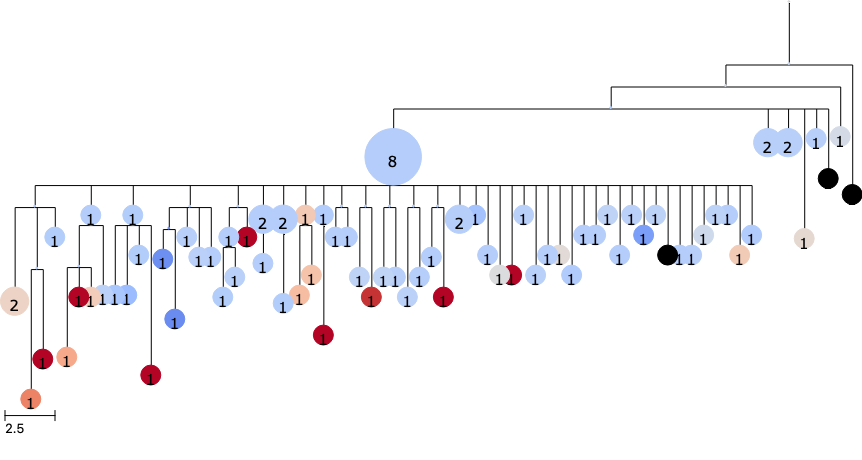

66-LA REI


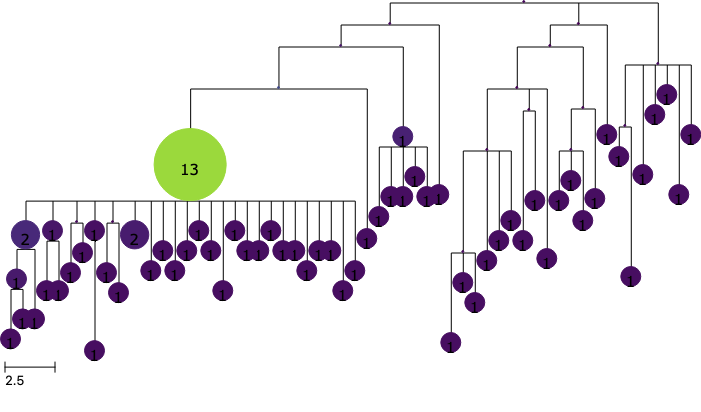

66-LA Δaffinity


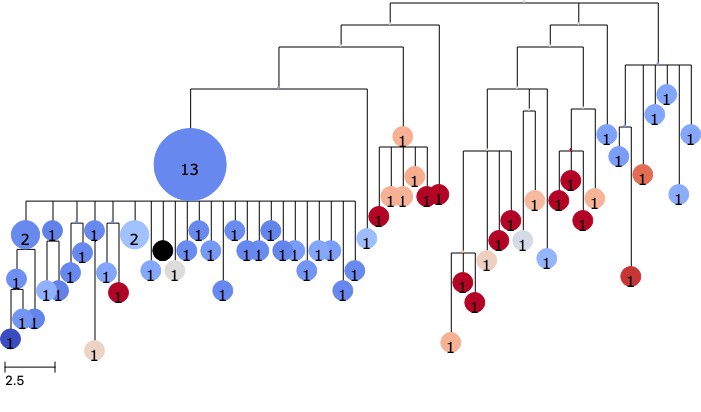

7-RI REI


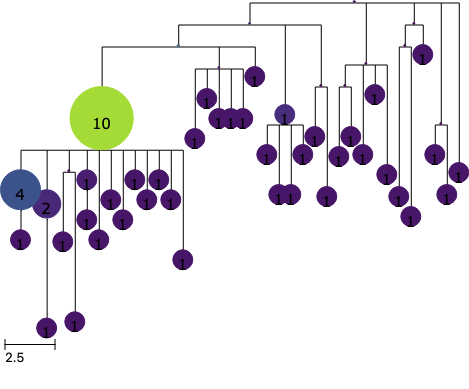

7-RI Δaffinity


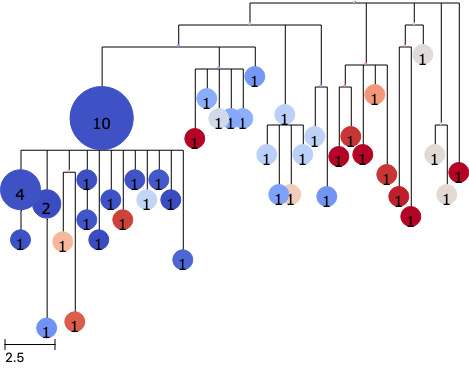

70-RA REI


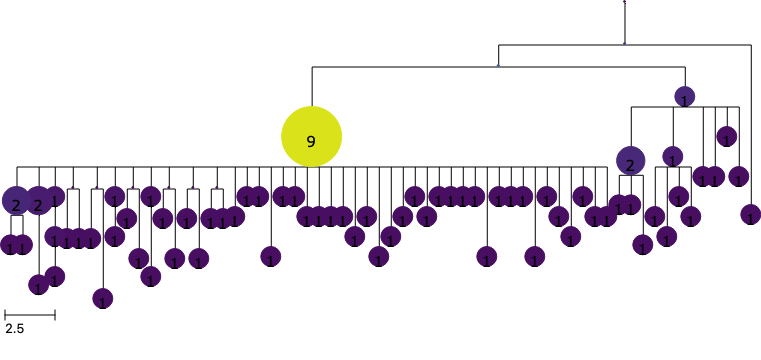

70-RA Δaffinity


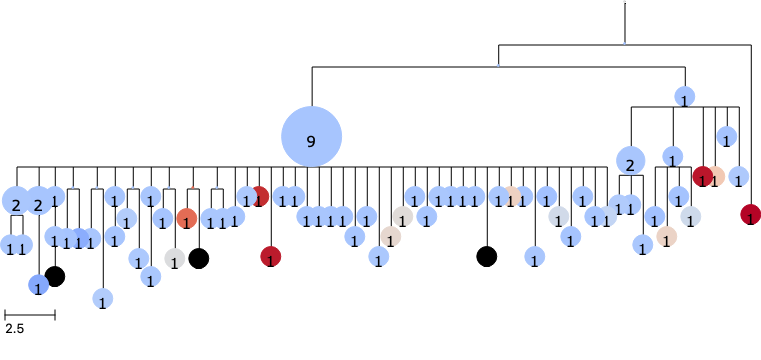

50-LP REI


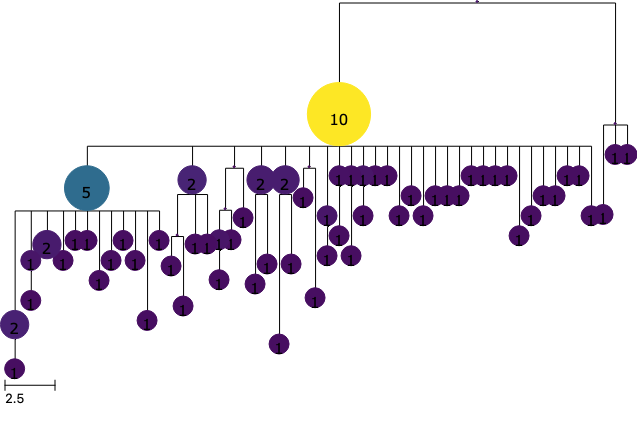

50-LP Δaffinity


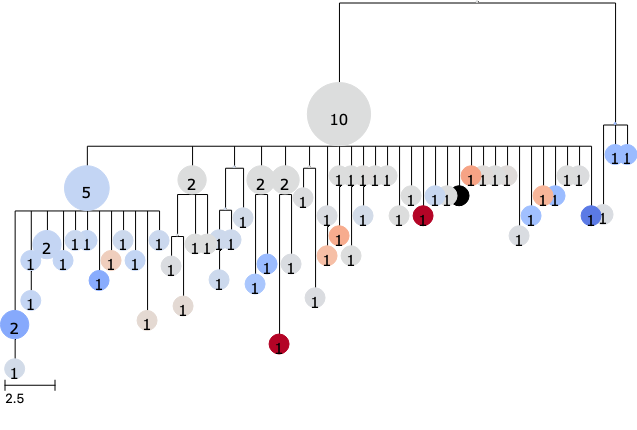

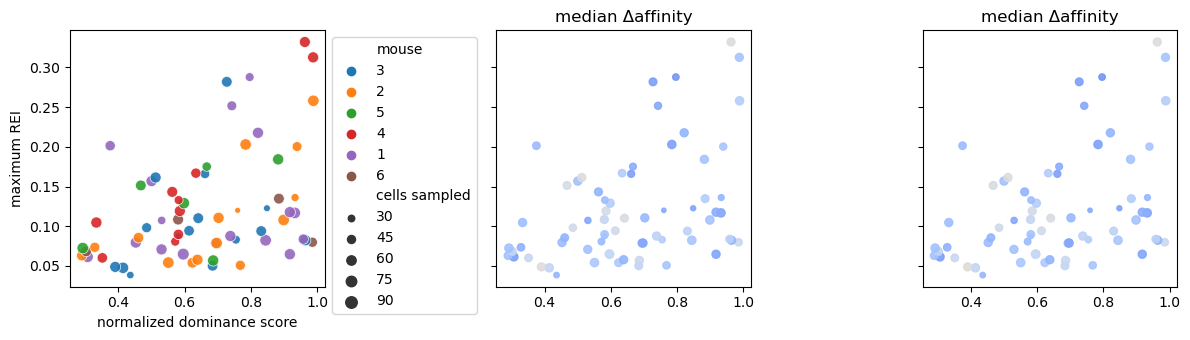

In [54]:
# stat cmap
cmap = "viridis"
vmin = min(getattr(node, stat) for tree in trees.values() for node in tree.tree.traverse())
vmax = max(getattr(node, stat) for tree in trees.values() for node in tree.tree.traverse())

# affinity cmap
cmap2 = "coolwarm_r"
vmin2 = -2
vmax2 = 2

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3.5), sharey=True)
sns.scatterplot(data=df, x="normalized dominance score", y=f"maximum {stat}", hue="mouse", size="cells sampled",
                clip_on=False, alpha=0.9,
                ax=ax1)
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
ax2.set_title("median Δaffinity")
ax2.scatter(df["normalized dominance score"], df[f"maximum {stat}"], c=df["median Δaffinity"], s=0.4 * df["cells sampled"],
                clip_on=False, alpha=0.9,
                cmap=cmap2, vmin=vmin2, vmax=vmax2)
ax3.set_title(outcome)
ax3.scatter(df["normalized dominance score"], df[f"maximum {stat}"], c=df[outcome], s=0.4 * df["cells sampled"],
                clip_on=False, alpha=0.9,
                cmap=cmap2, vmin=vmin2, vmax=vmax2)
# ax1.set_yscale("log")
# ax2.set_yscale("log")
# ax3.set_yscale("log")
for i, row in df.iterrows():
    x, y = row[["normalized dominance score", f"maximum {stat}"]]
    key = f"mouse{row.mouse}_GC{row['germinal center']}"
    colormap1 = trees[key].feature_colormap(stat, vmin=vmin, vmax=vmax, scale="symlog", linthresh=1, cmap=cmap)
    for scale in (5, 20):
        trees[key].render(f"{output_dir}/trees/{key}.{stat}.scale{scale}.svg", colormap=colormap1, scale=scale, branch_margin=-8)
    if row[f"maximum {stat}"] > thresh:
        print(row["germinal center"], stat)
        if row[f"max {stat} node is root"]:
            print(f"NOTE: max {stat} node is root")
        display(trees[key].render("%%inline", colormap=colormap1, scale=20, branch_margin=-8))
    colormap2 = trees[key].feature_colormap("delta_bind_CGG_FVS_additive", vmin=vmin2, vmax=vmax2, cmap=cmap2)
    for scale in (5, 20):
        trees[key].render(f"{output_dir}/trees/{key}.binding.scale{scale}.svg", colormap=colormap2, scale=scale, branch_margin=-8)
    if row[f"maximum {stat}"] > thresh:
        print(row["germinal center"], "Δaffinity")
        display(trees[key].render("%%inline", colormap=colormap2, scale=20, branch_margin=-8))
plt.tight_layout()
plt.savefig(f"{output_dir}/scatter.pdf")
plt.show()

## Color bars for the tree colormaps

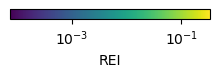

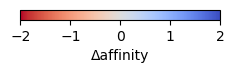

In [55]:
fig = plt.figure(figsize=(2, 1))
cax = fig.add_axes([0, 0, 1, 0.1])
plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax)),
             orientation='horizontal',
             cax=cax,
             label=f"{stat}")
plt.savefig(f"{output_dir}/cbar1.pdf", bbox_inches="tight")
plt.show()

fig = plt.figure(figsize=(2, 1))
cax = fig.add_axes([0, 0, 1, 0.1])
plt.colorbar(cm.ScalarMappable(cmap=cmap2, norm=Normalize(vmin=vmin2, vmax=vmax2)),
             orientation='horizontal',
             cax=cax,
             label="Δaffinity")
plt.savefig(f"{output_dir}/cbar2.pdf", bbox_inches="tight")
plt.show()

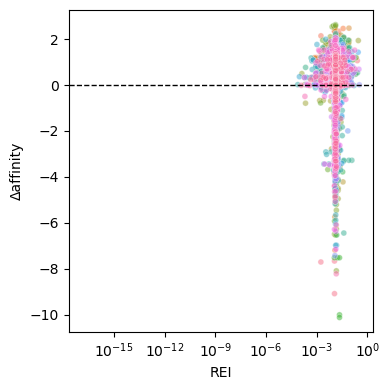

In [56]:
dat = []
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        dat.append([gc, getattr(node, stat), node.delta_bind_CGG_FVS_additive])

df_nodes = pd.DataFrame(dat, columns=["germinal center", stat, "Δaffinity"])

plt.figure(figsize=(4, 4))
sns.scatterplot(data=df_nodes, x=stat, y="Δaffinity", hue="germinal center", legend=False, alpha=0.5, size=.1)
plt.axhline(0, ls="--", c="k", lw=1)
plt.axvline(0, ls="--", c="k", lw=1)
plt.xscale("log")
plt.tight_layout()
plt.show()

## Summary

- Developed REI, because no branch lengths with LB
- Doesn't correlate will with GC affinity
- Recent motivated by evolving affinity

